In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata
from libpysal.weights import Queen
from spreg import ML_Lag
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# === Cargar shapefiles ===
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dataciones = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)
gdf_gradiente = gpd.read_file("C:/Git_SCA/AGE/Geotermica").to_crs(epsg=4326)

# === Generar pseudo-ausencias ===
gdf_depositos["Presencia"] = 1
num_depos = len(gdf_depositos)
rng = np.random.default_rng(42)
pseudo_points = []

while len(pseudo_points) < num_depos:
    x, y = rng.uniform(-80, -65), rng.uniform(-5, 15)
    pseudo_points.append(Point(x, y))

gdf_aus = gpd.GeoDataFrame(geometry=pseudo_points, crs="EPSG:4326")
gdf_aus["Presencia"] = 0

# === Unir datos y extraer coordenadas ===
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# === Interpolaciones ===
def interpolar(gdf, columna, grid_x, grid_y, filtro=None):
    gdf = gdf.copy()
    gdf[columna] = pd.to_numeric(gdf[columna].astype(str).str.replace(",", "."), errors="coerce")
    if filtro:
        gdf = gdf.query(filtro)
    coords = np.array([[p.x, p.y] for p in gdf.geometry])
    valores = gdf[columna].values
    grid = griddata(coords, valores, (grid_x, grid_y), method="cubic")
    grid[np.isnan(grid)] = griddata(coords, valores, (grid_x[np.isnan(grid)], grid_y[np.isnan(grid)]), method="nearest")
    return grid

grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_moho = interpolar(gdf_moho, "Z", grid_x, grid_y)
grid_edad = interpolar(gdf_dataciones, "EdadMa", grid_x, grid_y, "EdadMa <= 4000")
grid_grad = interpolar(gdf_gradiente, "GRADIENTE", grid_x, grid_y)

def sample_grid_value(x, y, grid, xmin=-80, xmax=-65, ymin=-5, ymax=15, n=500):
    ix = int((x - xmin) / ((xmax - xmin) / n))
    iy = int((ymax - y) / ((ymax - ymin) / n))
    if 0 <= ix < n and 0 <= iy < n:
        return grid[iy, ix]
    return np.nan

gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_moho), axis=1)
gdf_total["EdadMa"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_edad), axis=1)
gdf_total["Gradiente"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_grad), axis=1)

gdf_modelo = gdf_total.dropna(subset=["Moho_Z", "EdadMa", "Gradiente"])
gdf_modelo = gdf_modelo[gdf_modelo["EdadMa"] <= 4000].copy()

# === Modelo SAR ===
gdf_modelo = gdf_modelo.to_crs(epsg=3857)
w = Queen.from_dataframe(gdf_modelo)
w.transform = 'r'

X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]].values
y = gdf_modelo["Presencia"].values.reshape(-1, 1)

model = ML_Lag(y, X, w=w, name_y="Presencia", name_x=["Moho_Z", "EdadMa", "Gradiente"], name_w="Queen")
print(model.summary)


C:\TEMP\ipykernel_25952\512192838.py:68: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_modelo)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :   Presencia                Number of Observations:        1740
Mean dependent var  :      0.5092                Number of Variables   :           5
S.D. dependent var  :      0.5001                Degrees of Freedom    :        1735
Pseudo R-squared    :      0.8292
Spatial Pseudo R-squared:  0.3898
Log likelihood      :     69.0913
Sigma-square ML     :      0.0439                Akaike info criterion :    -128.183
S.E of regression   :      0.2095                Schwarz criterion     :    -100.874

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

C:\TEMP\ipykernel_25952\4135397734.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_modelo)
c:\Git_SCA\AGE\.venv\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


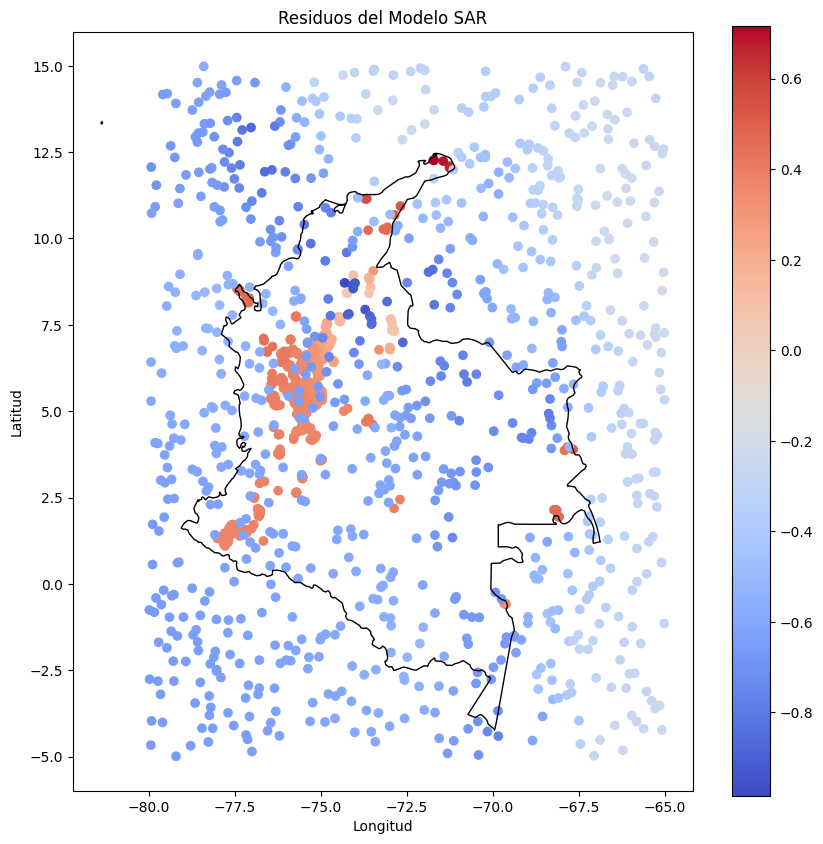

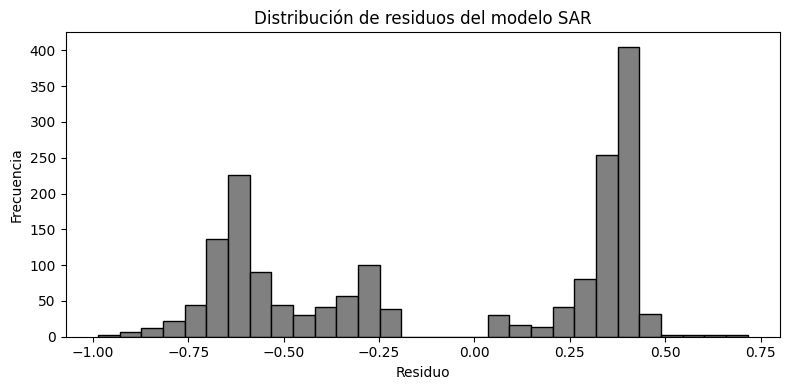

In [11]:
# Corrección del error de indexación y gráfico del modelo SAR
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from spreg import ML_Error

# === Asegurarse de que las columnas existen y acceden correctamente ===
X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]].values
y = gdf_modelo["Presencia"].values.reshape(-1, 1)
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)

# === Crear pesos espaciales (reina) ===
w = Queen.from_dataframe(gdf_modelo)
w.transform = 'r'

# === Ajustar modelo SAR (Spatial Error Model) ===
modelo_sar = ML_Error(y, X, w=w, name_y='Presencia', name_x=["Moho_Z", "EdadMa", "Gradiente"])

# === Añadir residuos al GeoDataFrame ===
gdf_modelo["residuos"] = modelo_sar.u

# === Convertir a EPSG:4326 para graficar correctamente ===
gdf_modelo = gdf_modelo.to_crs(epsg=4326)
area_col = area_col.to_crs(epsg=4326)

# === Mapa de residuos ===
fig, ax = plt.subplots(figsize=(10, 10))
area_col.boundary.plot(ax=ax, color='black', linewidth=1)
gdf_modelo.plot(column="residuos", cmap="coolwarm", ax=ax, legend=True)
plt.title("Residuos del Modelo SAR")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# === Histograma de residuos ===
plt.figure(figsize=(8, 4))
plt.hist(modelo_sar.u, bins=30, color="gray", edgecolor="black")
plt.title("Distribución de residuos del modelo SAR")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


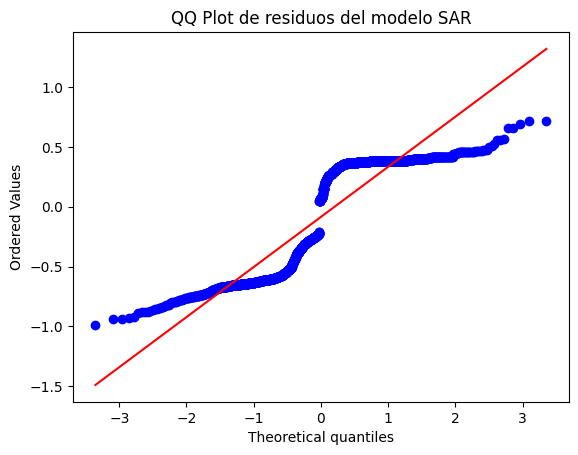

In [13]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(modelo_sar.u.flatten(), dist="norm", plot=plt)
plt.title("QQ Plot de residuos del modelo SAR")
plt.show()


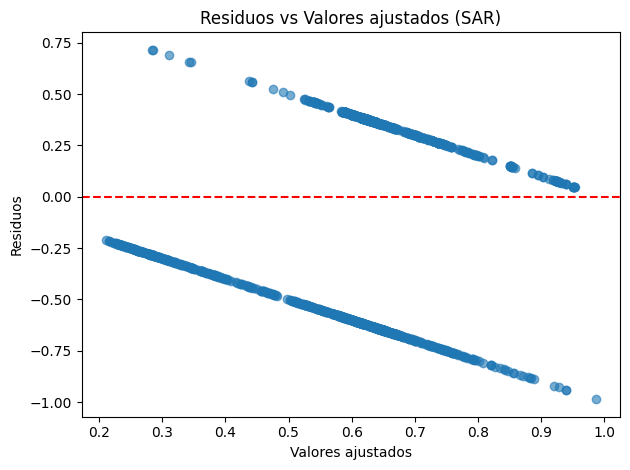

In [14]:
plt.scatter(modelo_sar.predy.flatten(), modelo_sar.u.flatten(), alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs Valores ajustados (SAR)")
plt.tight_layout()
plt.show()


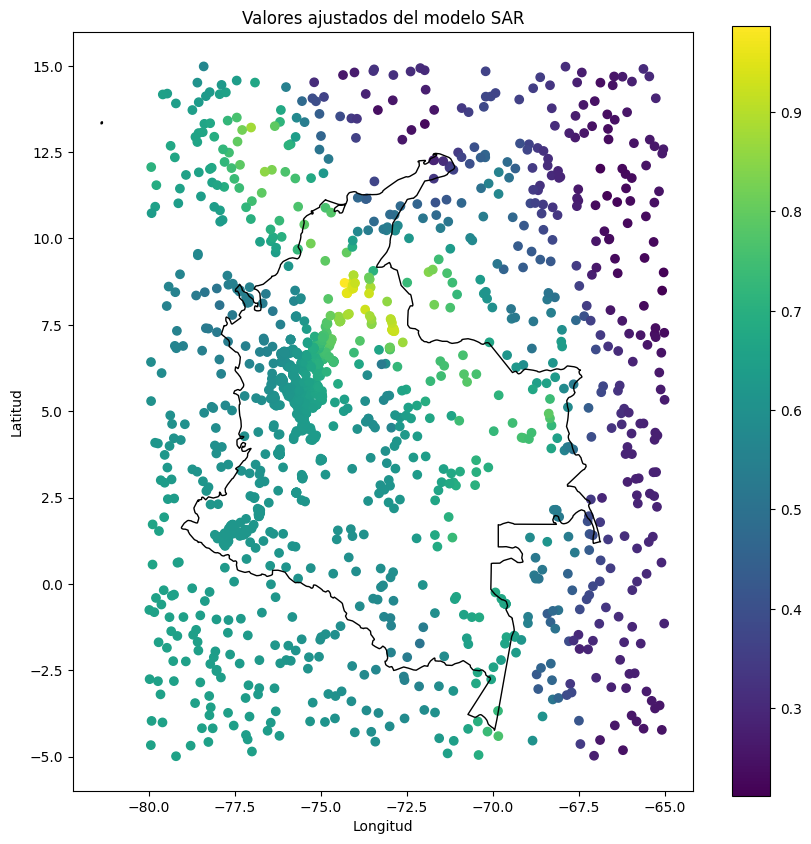

In [15]:
gdf_modelo["ajustado"] = modelo_sar.predy.flatten()

fig, ax = plt.subplots(figsize=(10, 10))
area_col.boundary.plot(ax=ax, color='black', linewidth=1)
gdf_modelo.plot(column="ajustado", cmap="viridis", ax=ax, legend=True)
plt.title("Valores ajustados del modelo SAR")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [18]:
from esda.moran import Moran

moran_res = Moran(modelo_sar.u, w)
print(f"Estadístico de Moran para los residuos: {moran_res.I:.4f}")
print(f"p-valor: {moran_res.p_sim:.4f}")

Estadístico de Moran para los residuos: 0.8008
p-valor: 0.0010


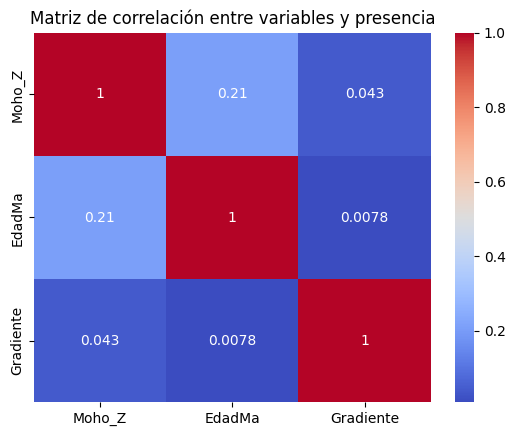

In [21]:
# === Matriz de correlación incluyendo presencia ===
df_vars = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]]
sns.heatmap(df_vars.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables y presencia")
plt.show()